# Solving Titanic Kaggle Challenge with a Neural Network

In [1]:
import torch
from torch import nn
import torch.optim as optim

import pandas as pd
import os
from torch.utils.data import DataLoader, TensorDataset
import seaborn as sns

import matplotlib.pyplot as plt

from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, accuracy_score

## Choose a model

In [2]:
# Here we define our model
# It is a simple feedforward neural network

# Input Layer --> number of features from our dataset
# Hidden Layers
# Activation Function: ReLU (Rectified Linear Unit) --> this is for introducing non-linearity
# Output Layer: 1 neuron with a sigmoid activation function, representing the survival probability
class TitanicNN(nn.Module):
    def __init__(self, input_size):
        super(TitanicNN, self).__init__()

        # This is the first hidden layer with 128 neurons
        # It takes the input features and applies a linear transformation followed by the ReLU activation function
        self.fc1 = nn.Linear(input_size, 128)

        # Second hidden layer with 64 neurons. It takes the output of the first hidden layer and applies another
        # linear transformation followed by the ReLU activation function
        self.fc2 = nn.Linear(128, 64)

        # Output layer with 1 neuron. It takes the output of the second hidden layer and applies a linear transformation
        # followed by the sigmoid activation function.
        self.fc3 = nn.Linear(64, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.sigmoid(self.fc3(x))
        return x

In [18]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

#device = "cpu" # uncomment if you want to use "cpu", currently cpu is faster than cuda (maybe because the NN is very little)
print(f"Using {device} device")

number_of_featuers = 5
model = TitanicNN(number_of_featuers).to(device)
print(model)

Using cuda device
TitanicNN(
  (fc1): Linear(in_features=5, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=1, bias=True)
  (relu): ReLU()
  (sigmoid): Sigmoid()
)


## Choose a loss function

For binary classification tasks, the most common choice of loss function is the binary cross-entropy loss (log loss).

In [19]:
loss_function = nn.BCELoss()

## Choose an optimizer

For tasks like this, the Adam optimizer is a widely used choice due to its adaptive learning rate and good performance in practice.

In [20]:
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# You can adjust the learning rate (lr) parameter in the optim.Adam call to control the step size during optimization.
# Experiment with different learning rates to find the one that works best for your specific task and model architecture.

## Train the model

In [21]:
# loads just the training data
# returns two DataFrames, one with just the features and one with the labels
def load_titanic_train_preprocessed():
    train_preprocessed = pd.read_csv(os.path.join('data', 'train_preprocessed.csv'))
    train_preprocessed_features = train_preprocessed.drop('Survived', axis=1)
    train_preprocessed_label = train_preprocessed['Survived']
    return train_preprocessed_features, train_preprocessed_label

In [22]:
train_features, train_labels = load_titanic_train_preprocessed()

# convert to PyTorch tensors
features_tensors = torch.tensor(train_features.values, dtype=torch.float32)
targets_tensors = torch.tensor(train_labels.values, dtype=torch.float32)

# Create a TensorDataset
dataset = TensorDataset(features_tensors, targets_tensors)

# Define data loader
# It contains both the features and the labels
batch_size = 32
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [30]:
# Training loop
model.train(mode=True)

num_epochs = 1000
losses = []
for epoch in range(num_epochs):
    for batch_inputs, batch_targets in data_loader:
        # batch_inputs --> my features
        # batch_targets --> my expected labels

        # Clear gradients from previous iteration
        optimizer.zero_grad()

        # now we make predictions from our model
        batch_outputs = model(batch_inputs.to(device))

        # and we calculate the loss by comparing the predictions against our expected labels
        # since batch_targets has shape [32] (1 row, 32 cols) and batch_outputs has [32,1]
        # (32 rows, 1 col), we do an unsqueeze here to change the shape of batch_targets
        loss = loss_function(batch_outputs, batch_targets.unsqueeze(1).to(device))
        losses.append(loss.item())

        # Backpropagate gradients
        loss.backward()

        # Update model parameters
        optimizer.step()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}')

model.train(mode=False)

Epoch [1/1000], Loss: 0.3109673857688904
Epoch [2/1000], Loss: 0.6479971408843994
Epoch [3/1000], Loss: 0.3825162947177887
Epoch [4/1000], Loss: 0.17077624797821045
Epoch [5/1000], Loss: 0.38870006799697876
Epoch [6/1000], Loss: 0.30208325386047363
Epoch [7/1000], Loss: 0.4240924119949341
Epoch [8/1000], Loss: 0.13366830348968506
Epoch [9/1000], Loss: 0.2725965082645416
Epoch [10/1000], Loss: 0.30931514501571655
Epoch [11/1000], Loss: 0.42418360710144043
Epoch [12/1000], Loss: 0.46960535645484924
Epoch [13/1000], Loss: 0.36583560705184937
Epoch [14/1000], Loss: 0.3192145526409149
Epoch [15/1000], Loss: 0.24259889125823975
Epoch [16/1000], Loss: 1.1522506475448608
Epoch [17/1000], Loss: 0.26557207107543945
Epoch [18/1000], Loss: 0.38752514123916626
Epoch [19/1000], Loss: 0.3337956666946411
Epoch [20/1000], Loss: 0.3125295639038086
Epoch [21/1000], Loss: 0.16408157348632812
Epoch [22/1000], Loss: 0.828350841999054
Epoch [23/1000], Loss: 0.40357986092567444
Epoch [24/1000], Loss: 0.698358

TitanicNN(
  (fc1): Linear(in_features=5, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=1, bias=True)
  (relu): ReLU()
  (sigmoid): Sigmoid()
)

<Axes: >

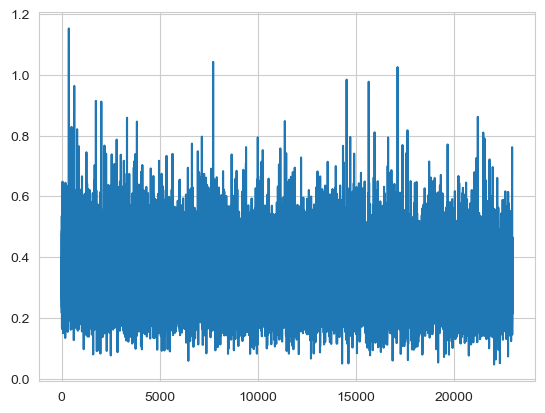

In [31]:
sns.lineplot(losses)

# Make predictions

In [32]:
# loads just the test data
# returns two DataFrames, one with just the features and one with the labels
def load_titanic_train_test_preprocessed():
    train_test_preprocessed = pd.read_csv(os.path.join('data', 'train_test_preprocessed.csv'))
    train_test_preprocessed_features = train_test_preprocessed.drop('Survived', axis=1)
    train_test_preprocessed_label = train_test_preprocessed['Survived']
    return train_test_preprocessed_features, train_test_preprocessed_label

In [33]:
def create_report(predictions, expected_labels):
    ConfusionMatrixDisplay.from_predictions(expected_labels, predictions)
    plt.show()
    print("The test score is ", accuracy_score(expected_labels, predictions))

    ## for the next methods:
    ## if pos_label is not given, it just calculates the f1_score for pos_label=1
    ## with average="weighted", we can define to calculate the average weighted for all labels
    ## with average="macro", we get the unweighted mean (label imbalance is not taken into account)


    ## precision score: TP / (TP + FP) ==> the more false positives I have, the smaller the precision score
    print("The precision score is ", precision_score(expected_labels, predictions, average="weighted"))

    ## recall score: TP / (TP + FN) ==> the more false negatives I have, the smaller the recall score
    print("The recall score is ", recall_score(expected_labels, predictions, average="weighted"))

    ## f1 score: combination of precision and recall score
    print("The f1 score is ", f1_score(expected_labels, predictions, average="weighted"))
    print(classification_report(expected_labels, predictions))

In [34]:
test_features, test_labels = load_titanic_train_test_preprocessed()

# convert to PyTorch tensors
test_features_tensors = torch.tensor(test_features.values, dtype=torch.float32)

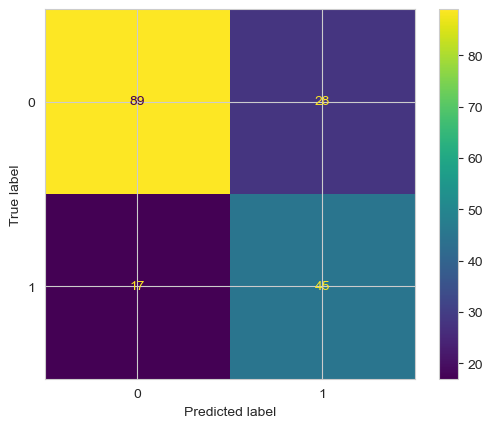

The test score is  0.7486033519553073
The precision score is  0.7623185873675731
The recall score is  0.7486033519553073
The f1 score is  0.7526450718574376
              precision    recall  f1-score   support

           0       0.84      0.76      0.80       117
           1       0.62      0.73      0.67        62

    accuracy                           0.75       179
   macro avg       0.73      0.74      0.73       179
weighted avg       0.76      0.75      0.75       179



In [35]:
predicted_labels = model(test_features_tensors.to(device))

# The predicted_labels contain values between 0 and 1.
# We apply a threshold to make a binary classification.
threshold = 0.5
binary_predictions = [1 if prob >= threshold else 0 for prob in predicted_labels]
create_report(binary_predictions, test_labels)